In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage
from langchain_core.runnables import RunnableConfig

In [2]:
from langchain_openai import ChatOpenAI
import re
model: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

pattern = r"<think>[\s\S]*?<\/think>"


## Memory

In [3]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
import os

db_path = "state_db/example.db"
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

## State

In [4]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    summary: str

## Node

In [5]:
def call_model(state: State, config: RunnableConfig):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = model.invoke(messages, config)
    
    return {"messages": response}

In [6]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = f"Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)] # nếu đảo lại là sẽ bị dính 2 human mesages -> invoke kh có kết quả

    response = model.invoke(messages)
    response = re.sub(pattern, "", response.content)
    
    delete_msg = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"messages": delete_msg, "summary": response}

## Build graph

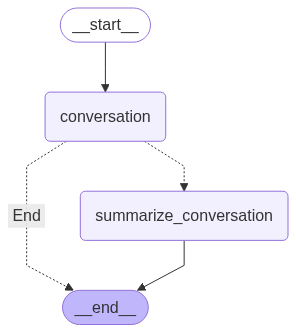

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

def should_continue(state: State):
    return "summarize_conversation" if len(state["messages"]) > 6 else "End"


workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "End": END         
    }
)
workflow.add_edge("summarize_conversation", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

In [9]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)


{'conversation': {'messages': AIMessage(content='<think>\nOkay, the user said "hi! I\'m Lance." So they\'re introducing themselves as Lance. I need to respond appropriately.\n\nFirst, I should acknowledge their greeting. Maybe say something like "Hello!" or "Hi there!" to be friendly.\n\nThen, since they introduced themselves as Lance, I can ask how they\'re doing or what they\'re up to. That keeps the conversation open and invites them to share more.\n\nI should keep the tone positive and welcoming. Maybe add an emoji to make it friendlier, like a smiley face.\n\nAlso, check if there\'s any specific context or previous interaction that needs to be considered. But since this is just a greeting, I\'ll stick to a general response.\n\nMake sure the response is concise but not too short. Let them know I\'m here to help and ask if they need anything.\n</think>\n\nHello! Hi there! I\'m Lance. How are you doing today? 😊 What\'s on your mind? I\'d love to hear more about what you\'re up to or 

In [10]:
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

<think>
Okay, the user said "hi! I'm Lance." So they're introducing themselves as Lance. I need to respond appropriately.

First, I should acknowledge their greeting. Maybe say something like "Hello!" or "Hi there!" to be friendly.

Then, since they introduced themselves as Lance, I can ask how they're doing or what they're up to. That keeps the conversation open and invites them to share more.

I should keep the tone positive and welcoming. Maybe add an emoji to make it friendlier, like a smiley face.

Also, check if there's any specific context or previous interaction that needs to be considered. But since this is just a greeting, I'll stick to a general response.

Make sure the response is concise but not too short. Let them know I'm here to help and ask if they need anything.
</think>

Hello! Hi there! I'm 

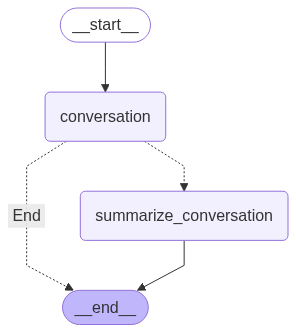

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
import aiosqlite
import os

db_path = "state_db/as_stream_event.db"
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = aiosqlite.connect(db_path, check_same_thread=False)
memory = AsyncSqliteSaver(conn)


def should_continue(state: State):
    return "summarize_conversation" if len(state["messages"]) > 6 else "End"


workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "End": END
    }
)
workflow.add_edge("summarize_conversation", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(
        f"Node: {event['metadata']}. Type: {event['event']}. Name: {event['name']}")

Node: {'thread_id': '3'}. Type: on_chain_start. Name: LangGraph
Node: {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation',), 'langgraph_path': ('__pregel_pull', 'conversation'), 'langgraph_checkpoint_ns': 'conversation:1a83fc7e-e258-95e2-2d72-6f617d53d94a'}. Type: on_chain_start. Name: conversation
Node: {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation',), 'langgraph_path': ('__pregel_pull', 'conversation'), 'langgraph_checkpoint_ns': 'conversation:1a83fc7e-e258-95e2-2d72-6f617d53d94a', 'checkpoint_ns': 'conversation:1a83fc7e-e258-95e2-2d72-6f617d53d94a', 'ls_provider': 'openai', 'ls_model_name': 'gpt-3.5-turbo', 'ls_model_type': 'chat', 'ls_temperature': 0.0}. Type: on_chat_model_start. Name: ChatOpenAI
Node: {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation',), 'langgraph_pa

In [14]:
node_to_stream = "conversation"
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["metadata"].get("langgraph_node") == node_to_stream and event["event"] == "on_chat_model_stream":
        print(event["data"])

{'chunk': AIMessageChunk(content='<think>', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content='\n', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content='Okay', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content=' I', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content=' need', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content=' to', additional_kwargs={}, response_metadata={}, id='run--9db02500-4ce8-4568-baa0-774ee105d16c')}
{'chunk': AIMessageChunk(content=' explain', additional_kwargs={},